# Importing

In [1]:
import numpy as np
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
import networkx as nx
import cvxpy as cp

# Constants

In [2]:
N = 10
n_i = np.array([1 for i in range(N)])
n = n_i.sum()
p = 1
q = 1
m = p + q                       

In [3]:
a = np.random.uniform(0, 2, n)

# b = np.random.uniform(-5, 5, n)
b = np.zeros(n)

# c = np.random.uniform(0, 2, n)
c = np.zeros(n)

d = np.random.uniform(0, 1, n)

pi = np.random.uniform(0, 2, n)

zeta = np.random.uniform(-2, 0, n)

gamma = np.random.uniform(-1, 1, n)         

delta = np.random.uniform(-2, 2, n)

# Solving via CVXPY

In [4]:
x = cp.Variable(n)

func = 0
ineq = 0
eq = 0

for i in range(N):
    func += a[i] * x[i] ** 2 + b[i] * x[i] + c[i] * cp.logistic(d[i] * x[i])
    ineq += pi[i] * x[i] ** 2 + zeta[i]
    eq += gamma[i] * x[i] + delta[i]

obj = cp.Minimize(func)

constraints = [ineq <= 0,
               eq == 0,
               x >= -1,
               x <= 1]

prob = cp.Problem(obj, constraints)

In [5]:
prob.solve()

1.05265335730323

In [6]:
x_opt = x.value
x_opt

array([ 0.23464004, -0.41974964,  1.        , -0.16497716, -0.14009286,
        0.027029  ,  0.12011388,  0.77484923,  1.        ,  0.61809893])

In [7]:
lambda_opt = np.array([constraints[0].dual_value, constraints[1].dual_value])
lambda_opt

array([ 1.07937451e-10, -8.27867955e-01])

# Network graph

In [8]:
G = nx.cycle_graph(N) # creating a graph
A = nx.to_numpy_array(G) # adjacency matrix

d = A.sum(axis=1)
D = np.diag(d)

L = D - A

# Algorithm implementation

In [9]:
def parse(x):
    cum = [0, *np.cumsum(n_i)]
    x_array = []
    for i in range(N):
        # x_array.append(x[cum[i]:cum[i+1]])
        # in our case there are scalars
        x_array.append(x[cum[i]:cum[i+1]][0])
    return np.array(x_array)

In [10]:
def f_i(i, x_i):
    return a[i] * x_i ** 2 + b[i] * x_i + c[i] * np.log(1 + np.exp(d[i] * x_i))

def g_i(i, x_i):
    return pi[i] * x_i ** 2 + zeta[i]

def h_i(i, x_i):
    return gamma[i] * x_i + delta[i]


def f(x):
    x_array = parse(x)
    return np.array([f_i(i, x_array[i]) for i in range(N)]).sum()

def g(x):
    x_array = parse(x)
    return np.array([g_i(i, x_array[i]) for i in range(N)]).sum()

def h(x):
    x_array = parse(x)
    return np.array([h_i(i, x_array[i]) for i in range(N)]).sum()

In [11]:
def grad_f_i(i, x_i):
    return 2 * a[i] * x_i + b[i] + c[i] * d[i] * np.exp(d[i] * x_i) / (1 + np.exp(d[i] * x_i))

def grad_g_i(i, x_i):
    return 2 * pi[i] * x_i

def grad_h_i(i, x_i):
    return gamma[i]

def grad_f(x):
    x_array = parse(x)
    return np.hstack(tuple([grad_f_i(i, x_array[i]) for i in range(N)]))

In [12]:
def psi_i(i, x_i):
    return np.hstack((g_i(i, x_i), h_i(i, x_i)))

def psi(x):
    x_array = parse(x)
    return np.array([psi_i(i, x_array[i]) for i in range(N)]).sum(axis=0)

In [13]:
def grad_psi_i(i, x_i):
    return np.vstack((grad_g_i(i, x_i), grad_h_i(i, x_i)))

def grad_psi(x):
    x_array = parse(x)
    return np.hstack(tuple([grad_psi_i(i, x_array[i]) for i in range(N)]))

def psi_tilde(x):
    x_array = parse(x)
    return np.hstack(tuple([psi_i(i, x_array[i]) for i in range(N)]))

def grad_psi_tilde(x):
    x_array = parse(x)
    return block_diag(*[grad_psi_i(i, x_array[i]) for i in range(N)])

In [14]:
def P_Omega_i(x_i):
    if x_i < -1:
        return -1
    elif -1 <= x_i <= 1:
        return x_i
    else:
        return 1
    
def P_Omega(x):
    x_array = parse(x)
    return np.hstack(tuple([P_Omega_i(x_array[i]) for i in range(N)]))

def P_Theta_i(lmbd_i):
    p1 = lmbd_i[0] if lmbd_i[0] >= 0 else 0
    p2 = lmbd_i[1]
    return np.array([p1, p2])

def P_Theta(lmbd):
    return np.hstack(tuple([P_Theta_i(lmbd[i:i+m]) for i in range(0, m*N, 2)]))

In [15]:
def eps(k):
    return np.array([10 / np.exp(0.01 * (k+1)) for _ in range(N)])

In [16]:
# event-triggered mechanism

def ETDOA(alpha, beta, x0, lmbd0, s0, n_iter):

    xm1 = x0
    lmbdm1 = lmbd0

    x_k = np.zeros((n_iter, n))
    lmbd_k = np.zeros((n_iter, m*N))
    lmbd_tilde_k = np.zeros((n_iter, m*N))
    s_k = np.zeros((n_iter, m*N))

    x_k[0] = xm1
    x_k[1] = x0

    lmbd_k[0] = lmbdm1
    lmbd_k[1] = lmbd0

    lmbd_tilde_k[1] = lmbd0

    s_k[1] = s0

    C = np.ones(N) # communication numbers

    k = 1

    while k <= n_iter-2:

        # updates
        x_k[k+1] = P_Omega(x_k[k] - 2 * alpha * (grad_f(x_k[k]) + grad_psi_tilde(x_k[k]).T @ lmbd_k[k]) + alpha * (grad_f(x_k[k-1]) + grad_psi_tilde(x_k[k-1]).T @ lmbd_k[k-1]))
        lmbd_k[k+1] = P_Theta(lmbd_k[k] + 2 * alpha * psi_tilde(x_k[k]) - alpha * psi_tilde(x_k[k-1]) - alpha * s_k[k] - alpha * beta * np.kron(L, np.identity(m)) @ lmbd_tilde_k[k])
        
        # test the event-triggered rule
        for i, j in zip(range(0, m*N, 2), range(N)):
            if np.linalg.norm(lmbd_tilde_k[k][i:i+m] - lmbd_k[k][i:i+m]) > eps(k)[j]:
                C[j] += 1
                lmbd_tilde_k[k+1][i:i+m] = lmbd_k[k+1][i:i+m]
            else:
                lmbd_tilde_k[k+1][i:i+m] = lmbd_tilde_k[k][i:i+m]
        
        # update the local update
        s_k[k+1] = s_k[k] + beta * np.kron(L, np.identity(m)) @ lmbd_tilde_k[k+1]
    
        k = k + 1
    
    return x_k, C

In [17]:
# periodic communication

def PDOA(alpha, beta, x0, lmbd0, s0, n_iter):

    xm1 = x0
    lmbdm1 = lmbd0

    x_k = np.zeros((n_iter, n))
    lmbd_k = np.zeros((n_iter, m*N))
    s_k = np.zeros((n_iter, m*N))

    x_k[0] = xm1
    x_k[1] = x0

    lmbd_k[0] = lmbdm1
    lmbd_k[1] = lmbd0

    s_k[1] = s0

    C = np.ones(N) # communication numbers

    k = 1

    while k <= n_iter-2:

        # updates
        x_k[k+1] = P_Omega(x_k[k] - 2 * alpha * (grad_f(x_k[k]) + grad_psi_tilde(x_k[k]).T @ lmbd_k[k]) + alpha * (grad_f(x_k[k-1]) + grad_psi_tilde(x_k[k-1]).T @ lmbd_k[k-1]))
        lmbd_k[k+1] = P_Theta(lmbd_k[k] + 2 * alpha * psi_tilde(x_k[k]) - alpha * psi_tilde(x_k[k-1]) - alpha * s_k[k] - alpha * beta * np.kron(L, np.identity(m)) @ lmbd_k[k])
        # update the local update
        s_k[k+1] = s_k[k] + beta * np.kron(L, np.identity(m)) @ lmbd_k[k+1]
    
        C += np.ones(N)

        k = k + 1
    
    return x_k, C

# Numerical experiment

In [18]:
# step sizes

# alpha = 0.15
# beta = 1.2

k_c = 10

alpha = 1 / 2 * 1 / (3 * k_c)
beta = 1 / 2 * (1 - 3 * alpha * k_c) / (alpha * np.linalg.eigvals(L).max())

print(f"alpha = {alpha}, beta = {beta}")

alpha = 0.016666666666666666, beta = 3.7499999999999987


In [19]:
x_k_ET, C_ET = ETDOA(alpha=alpha, beta=beta, x0=np.zeros(n), lmbd0=np.zeros(m*N), s0=np.zeros(m*N), n_iter=2000)
x_k_P, C_P = PDOA(alpha=alpha, beta=beta, x0=np.zeros(n), lmbd0=np.zeros(m*N), s0=np.zeros(m*N), n_iter=2000)

In [20]:
[int(C_i) for C_i in C_ET]

[813, 766, 808, 813, 829, 817, 767, 812, 812, 825]

In [21]:
[int(C_i) for C_i in C_P]

[1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999]

Text(0, 0.5, 'Squared error')

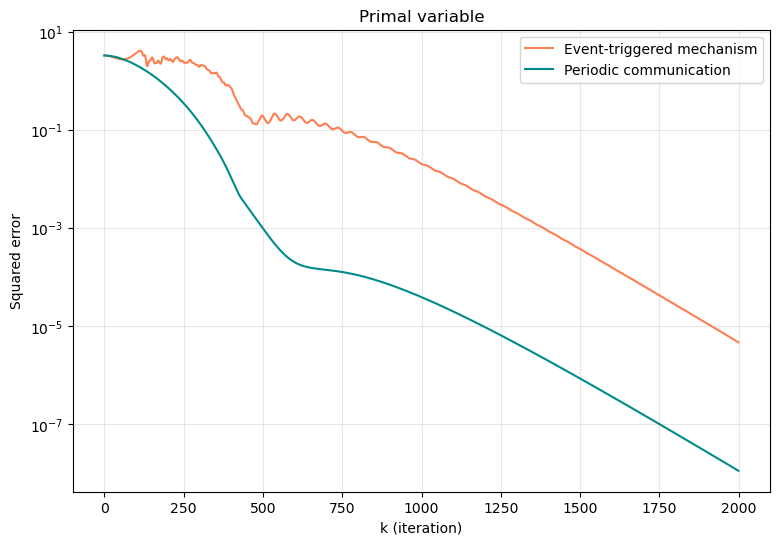

In [22]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_ET.shape[0]), [np.linalg.norm(x_k_ET[k] - x_opt)**2 for k in range(x_k_ET.shape[0])], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(x_k_P.shape[0]), [np.linalg.norm(x_k_P[k] - x_opt)**2 for k in range(x_k_P.shape[0])], color = 'darkcyan', label="Periodic communication")

#plt.xlim(0, 100)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("k (iteration)")
plt.ylabel("Squared error")

Text(0, 0.5, '$|f(x_k) - f(x^*)|$')

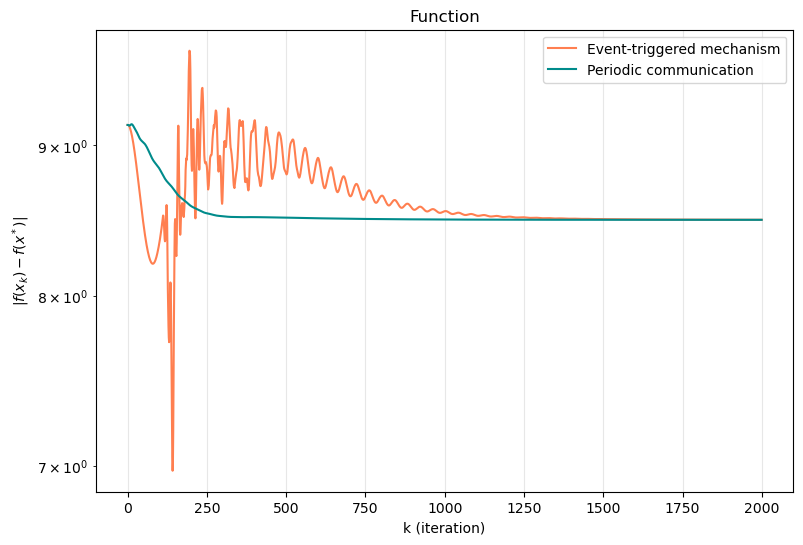

In [23]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_ET.shape[0]), [abs(f(x_k_ET[k] - f(x_opt))) for k in range(x_k_ET.shape[0])], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(x_k_P.shape[0]), [abs(f(x_k_P[k] - f(x_opt))) for k in range(x_k_P.shape[0])], color = 'darkcyan', label="Periodic communication")

#plt.xlim(0, 100)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Function")
plt.xlabel("k (iteration)")
plt.ylabel("$|f(x_k) - f(x^*)|$")